In [1]:
# General
import os
import sys
import time
import shutil
import funcy as fp
import numpy as np
import pandas as pd
from functools import partial

# Verificação de tipos
from typing import List, Tuple, Dict

# Visualization / Presentation
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, display

# Bibliotecas e Funções para NLP
import re
import fasttext
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

# Redução de Dimensionalidade e Análise de Similaridade
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.special import softmax

# Treinamento e Avaliação de Modelos
from sklearn import metrics
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier

# Algoritmos adicionais para a criação de modelos
from catboost import CatBoostClassifier

# Rastreamento de experimentos e modelos
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature

# Recursos para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, display

# Carregar, além de atualizar frequentemente, código personalizado disponível em ../src
%load_ext autoreload 
%autoreload 2
sys.path.append(os.path.abspath(os.path.pardir))
from src import settings
from src.utils.notebooks import display_side_by_side
from src.utils.experiments import (set_dataset_split, 
                                   compute_multiclass_classification_metrics,
                                   format_nested_parameters)
from src.utils.text import clean_text
from src.pipeline.wrappers import PreprocessingWrapper

# Configurações para a exibição de conteúdo do Pandas e das bibliotecas gráficas
%matplotlib inline 
sns.set(rc={'figure.figsize':(25,10)})
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 150)

# Importante: Este notebook está em estágio inicial de desenvolvimento

TODO (ou devaneios):
 - Avaliar eficácia de pré-processar conteúdo textual;
 - Usar forma mais personalizada de preenchimento de valores ausentes;
 - Normalizar dados para fazer experimentação com modelos além do Catboost;
 - Padronizar e criar wrapper para persistir pipeline e modelo do experimento;
 - Apresentar métricas de avaliação por algoritmo e por algoritmo + categoria;
 - Avaliar qual estratégia seguir para validação: 
   - Cross-validation orientada por tempo ou amostras aleatórias (provavelmente o segundo, considerando que o conjunto de teste já está separado para a avaliação final)
 - Experimentações diversas:
   - Avaliação de atributos;
   - Uso de embeddings para titulo, tags, titulo + tags;
   - Avaliar uso ou não de classes para balanceamento de categorias;
   - Avaliar estratégias para se lidar com produtos repetidos e com mudanças ao longo do tempo;
   - Analisar categorias com pior desempenho e verificar casos com erros;

# Classificação de Produtos em Categorias

Este notebook tem como propósito viabilizar os experimentos de criação de um classificador de produtos em categorias. Ainda que seja possível utilizar esse classificador para revisar produtos que possam estar categorizados de forma incorreta, é provável que exista um valor de utilização maior na possibilidade de classificar produtos recém cadastrados ou em processo de registro. Com isso, **não se deve esperar a disponibilidade de colunas relacionadas a busca ou às interações com os produtos**, como:
 - *query*
 - *search_page*
 - *position*
 - *view_counts*
 - *order_counts*
 
Uma **possibilidade** de incorporar algumas dessas informações, como visualizações e pedidos, seria a **de utilizar uma estatística (e.g., média ou mediana) de produtos similares** que já tinham sido cadastrados antes do momento da criação do produto em questão. Por exemplo, fazer a média dos 50 produtos com título e preço mais semelhantes. De início, esses campos e possibilidades não serão exploradas, considerando que **pode não existir volume suficiente para trazer informações representativas de todos os produtos**. Pelo mesmo motivo, provavelmente **não serão utilizadas estatísticas sobre vendedores**.

PS.: Se a qualidade do classificador não for satisfatória com as informações mínimas planejadas inicialmente, poderei apelar para as estratégias alternativas de incorporação dos demais campos. :0)

Além dos atributos que provavelmente não estarão disponíveis no momento de uso do classificador, é preciso as variações das características dos produtos. Conforme a [Análise Exploratória](02_Analise_Exploratoria.ipynb), **preço (*price*), peso (*weight*), pronta entrega (*express_delivery*) e quantidade mínima (*minimum_quantity*) variam ao longo do tempo para um mesmo produto**. Assim, é preciso tomar uma decisão sobre como lidar com a repetição dos produtos nos dados:
 - Lidar apenas com produtos únicos:
   - Descartar atributos que variam;
   - ~Usar valor mais recente de cada atributo~ (não é viável sem data da busca);
   - Calcular estatística sobre valores que variam;
 - Usar repetições dos produtos e  re-balancear o peso deles no treinamento do modelo; 
 
 
A utilização de produtos repetidos, com características que mudam com o tempo, pode ser interessante para trazer mais varidade de dados ao modelo, como uma aumentação natural. Caso seja preciso, pode-se tentar simular esse processo para produtos que não estejam repetidos.

Com relação aos atributos textuais, a análise realizada indicou o maior potencial de uso de tags concatenadas e título. Além disso, foi possível notar que a similaridade entre o valor de um atributo textual e a média do mesmo atributo com relação a cada categoria funciona como um preditor razoável, semelhante a um KNN global. Pode-se explorar esse recurso como uma *feature* a mais no modelo.

## Configurações de Rastreamento de Experimentos

In [2]:
EXPERIMENT_NAME = '01_SupervisedClassification'
EXPERIMENT_RUN_NAME = f'Structuring'

mlflow_client = MlflowClient()

# Se o experimento já não existir no MlFlow, criar um e recuperar ID
experiment = mlflow_client.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    mlflow_client.create_experiment(EXPERIMENT_NAME)
    experiment = mlflow_client.get_experiment_by_name(EXPERIMENT_NAME)

EXPERIMENT_ID = experiment.experiment_id
del experiment

## Carregamento de Dados

Para trabalhar o problema de classificação de produtos em categorias, é preciso utilizar o conjunto de dados de treinamento, dividido em  [01_Estruturacao.ipynb](01_Estruturacao.ipynb).

In [3]:
columns_to_read = ['title', 'concatenated_tags', 'price', 'weight', 'express_delivery', 'minimum_quantity', 'category', 'creation_date']

frame = (pd
         .read_csv(os.path.join(settings.DATA_PATH, 'interim', 'training.csv'), usecols=columns_to_read)
         .drop_duplicates()  # Manter mais de uma ocorrência de produto apenas se existir variação nos dados
        )

Apesar de já existir uma separação de dados para teste, o ideal é mantê-la isolada até o momento da validação final. Assim, é preciso fazer uma nova separação para a experimentação com diferentes features. O período de separação será '2018-05', conforme utilizado em etapas anteriores de avaliação.

In [4]:
cut_off_period = '2018-05'
split_frame = set_dataset_split(frame, cut_off_period)

training_frame = split_frame.loc[lambda f: f['group'] != 'test'].drop(columns=['group'])
validation_frame = split_frame.loc[lambda f: f['group'] == 'test'].drop(columns=['group'])

display_side_by_side([training_frame.head(2).T, validation_frame.head(2).T],
                     ['Treinamento', 'Validação'],
                     padding=50)

,0,1
title,Mandala Espírito Santo,Cartão de Visita
concatenated_tags,mandala mdf,cartao visita panfletos tag adesivos copos long drink canecas
creation_date,2015-11-14 19:42:12,2018-04-04 20:55:07
price,171.89,77.67
weight,1200.0,8.0
express_delivery,1,1
minimum_quantity,4,5
category,Decoração,Papel e Cia
period,2015-11,2018-04
,4,7


## Gerar Vetor de Características

Conforme analisado em [Analise_Textual](02.1_Analise_Textual.ipynb), a primeira estratégia a ser explorada para trabalar com texto será utilizar *embeddings*. Com isso, espera-se contornar eventuais problemas com palavras fora do vocabulário e reduzir a dimensionalidade dos dados de treinamento. Adicionalmente, pode-se utilizar as informações de similaridade para fazer aumentação de dados textuais ou recuperar itens semelhantes para derivar outros valores (e.g., média de popularidade ou peso de de produtos semelhantes).

In [5]:
#ft_model = fasttext.load_model(os.path.join(settings.MODELS_PATH, 'cc.pt.300.bin'))
#ft_model_ref = 'cc.pt.300.bin'

Criar codificador das categorias dos produtos.

In [6]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(training_frame.category)

y_training = label_encoder.transform(training_frame.category)
y_validation = label_encoder.transform(validation_frame.category)

Está sendo desenvolvido para permitir a experimentação com diferentes abordagens de tratamento de features, saber:
 - **Embeddings de atributo textual**: Embeddings criados com o Word2Vect, com 300 dimensões, para representar atributos textuais;
 - **Similaridade entre os produtos de uma categoria**: Para cada categoria, calcula-se a similaridade entre a média dos embeddings de produtos da categoria e o item do conjunto de dados. Desse modo, pode-se sumarizar a medida dos embeddings sem utilizar 300 dimensões;
 - **Imputação de valores numéricos**: Criação de estatísticas que podem ser usadas para preencher dados numéricos ausentes -- importante para algoritmos que não têm algum mecanismo embutido para lidar com dados não preencidos. Essas estatísticas também podem ser utilizadas nos algoritmos não supervisionados, para atribuir um valor numérico ao produto simulado pela busca.

In [7]:
def compute_embeddings_frame(base_frame: pd.DataFrame, columns: List[str], ft_model_ref: str = 'cc.pt.300.bin') -> pd.DataFrame:
    """Para cada coluna indicada, cria uma coluna com a representação de embeddings de cada elemento."""

    ft_model = fasttext.load_model(os.path.join(settings.MODELS_PATH, ft_model_ref))

    embeddings_frame = pd.DataFrame()
    for column in columns:
        embeddings_frame[f'{column}_embedding'] = (
            base_frame
            .assign(**{f'{column}': lambda f: f[column].apply(lambda v: '' if pd.isna(v) else v)})
            [column]
            .str
            .lower()
            .apply(ft_model.get_sentence_vector)
        )
    return embeddings_frame


def compute_average_embeddings(base_frame: pd.DataFrame, columns: List[str], categories: List[str]) -> Dict[str, np.array]:
    """Gera um dicionário contendo como chave categorias e como valor a média dos embeddings de todos os elementos 
    do data frame para a categoria.
    """

    category_embeddings_dict = {}
    for category in categories:
        for column in columns:
            embeddings = np.stack(base_frame
                                  .loc[lambda f: f['category'] == category]
                                  [f'{column}_embedding']
                                  .to_numpy(),
                                  axis=0)
            category_embeddings_dict[(category, column)] = np.mean(embeddings, axis=0)

    return category_embeddings_dict


def compute_column_category_similarity(base_embeddings_frame: pd.DataFrame,
                                       categories_embeddings: dict,
                                       column: str,
                                       apply_softmax: bool = False) -> pd.DataFrame:

    """Adiciona, para cada categoria, qual a similaridade entre os elementos dela e os embeddings da coluna indicada"""

    similarity_frame = base_embeddings_frame[[]].copy()
    categories = sorted(set([category for category, _ in category_embeddings_dict.keys()]))
    similarity_columns = [f'similarity_{column}_{category.lower().replace(" ", "_")}' for category in categories]

    similarities_list = []
    for category in categories:
        column_embeddings = np.stack(base_embeddings_frame[f'{column}_embedding'].to_numpy(), axis=0)
        category_embedding = categories_embeddings[(category, column)]
        category_embedding = np.expand_dims(category_embedding, axis=0)

        similarities_list.append(cosine_similarity(category_embedding, column_embeddings))

    if apply_softmax:
        similarity_frame[similarity_columns] = softmax(np.concatenate(similarities_list, axis=0), axis=0).T
    else:
        similarity_frame[similarity_columns] = np.concatenate(similarities_list, axis=0).T

    return similarity_frame


def compute_stats_for_numeric_values(base_frame: pd.DataFrame, columns: List[str]) -> Dict[Tuple[str, str], float]:
    """Gera um dicionário aninhado contendo nome da coluna, estatística e valor"""

    return (base_frame
            [columns]
            .agg({np.median,
                  np.mean,
                  np.std
                 })
            .to_dict() 
           )


def fill_missing_numeric_values(base_frame: pd.DataFrame, numeric_stats_dict: dict, statistics: str = 'median') -> pd.DataFrame:
    """Função para preencher valores ausentes com dicionário contendo estatísticas de colunas"""

    filled_frame = base_frame.copy()
    for column in numeric_stats_dict.keys():
        filled_frame[column] = filled_frame[column].apply(lambda v: numeric_stats_dict['weight'][statistics])

    return filled_frame


def create_feature_matrix(base_frame: pd.DataFrame, feature_columns: List[str], embeddings_columns: List[str]) -> np.array:
    """Função para extrair e formatar features em uma matriz para treinamento/inferência"""

    embeddings_list = []
    for column in embeddings_columns:
        embedding_column = np.stack(base_frame[column].to_numpy(), axis=0)
        embeddings_list.append(embedding_column)

    basic_columns_list = [np.expand_dims(base_frame[column].to_numpy(), axis=1) 
                          for column in feature_columns]

    return np.concatenate(embeddings_list + basic_columns_list, axis=1)


def create_preprocessing_resources(base_frame: pd.DataFrame, 
                                   embeddings_columns: List[str], 
                                   numeric_columns: List[str],
                                   text_preprocessing_fn: partial) -> (List[str], Dict, Dict):
    """Função para criar dicionários e listas de referência para processar dados de treinamento e de teste"""

    categories = sorted(base_frame['category'].unique().tolist())
    columns_to_copy = ['category'] + embeddings_columns + numeric_columns

    # Limpar e gerar embeddings de colunas textuais selecionadas
    features_frame = (base_frame
                      [columns_to_copy]
                      .copy()
                      .fillna({c: '' for c in embeddings_columns})
                     )

    for feature in embeddings_columns:        
        features_frame[feature] = features_frame[feature].apply(text_preprocessing_fn)

    embeddings_frame = compute_embeddings_frame(base_frame, embeddings_columns)
    features_frame = pd.concat([features_frame, embeddings_frame], axis=1)

    # Gerar dicionário com os embeddings médios de cada categoria dos dados de treinamento
    category_embeddings_dict = compute_average_embeddings(features_frame, embeddings_columns, categories)

    # Gerar dicionário com estatísticas de valores numéricos para fazer imputação
    numerics_stats_dict = compute_stats_for_numeric_values(base_frame, numeric_columns)

    return categories, category_embeddings_dict, numerics_stats_dict


def preprocess_features(base_frame: pd.DataFrame,
                        categories: List[str],
                        category_embeddings: Dict,
                        numeric_stats: Dict,
                        numeric_features: List[str],
                        text_features: List[str],
                        similarity_features: List[str],
                        text_preprocessing_fn: partial
                       ) -> pd.DataFrame:
    """Função para fazer pre-processamento das features para treinamento, validação e teste"""

    columns_to_copy = ['category'] + numeric_features + text_features
    features_frame = (base_frame
                      [columns_to_copy]
                      .copy()
                      .fillna({c: '' for c in text_features})
                     )
    
    for feature in text_features:
        features_frame[feature] = features_frame[feature].apply(text_preprocessing_fn)

    # Calcular embeddings para colunas textuais
    embeddings_frame = compute_embeddings_frame(features_frame, text_features)
    features_frame = pd.concat([features_frame.drop(columns=text_features), embeddings_frame], axis=1)

    # Adicionar similaridade
    for feature in similarity_features:
        category_similarity_frame = compute_column_category_similarity(features_frame, category_embeddings_dict, feature)
        features_frame = pd.concat([features_frame, category_similarity_frame], axis=1)

    # Preencher valores numéricos
    features_frame = fill_missing_numeric_values(features_frame, numeric_stats)

    return features_frame

A partir das funções criadas, pode-se criar o conjunto de elementos para o conjunto de treinamento (lista de categorias, embeddings dos produtos da categoria e dicionário de estatísticas de números). Posteriormente, esses recursos são utilizados para se pré-processar os conjuntos de dados de treinamento e de validação.

In [8]:
# Variáveis para controlar features
text_columns_to_encode = ['title', 'concatenated_tags']
numeric_columns_to_impute = ['price', 'weight', 'minimum_quantity']
columns_to_copy = ['title', 'concatenated_tags', 'price', 'weight', 'minimum_quantity', 'category']
similarity_features = ['title', 'concatenated_tags']

# Pré-definição dos parâmetros para a função de limpeza de texto
partial_clean_text_fn = partial(clean_text,
                                unify_html_tags=False,
                                unify_urls=False,
                                trim_repeating_spaces=True,
                                unify_hashtags=False,
                                unify_mentions=False,
                                unify_numbers=False,
                                trim_repeating_letters=True)

# Dicionários e recursos pré-computados para pré-processar features
categories_list, category_embeddings_dict, numeric_stats_dict = create_preprocessing_resources(training_frame, 
                                                                                               text_columns_to_encode, 
                                                                                               numeric_columns_to_impute,
                                                                                               partial_clean_text_fn)

training_features_frame = preprocess_features(training_frame, 
                                             categories_list, 
                                             category_embeddings_dict, 
                                             numeric_stats_dict, 
                                             numeric_columns_to_impute, 
                                             text_columns_to_encode, 
                                             similarity_features,
                                             partial_clean_text_fn)

validation_features_frame = preprocess_features(validation_frame, 
                                                categories_list, 
                                                category_embeddings_dict, 
                                                numeric_stats_dict, 
                                                numeric_columns_to_impute,
                                                text_columns_to_encode, 
                                                similarity_features,
                                                partial_clean_text_fn)

As *features* criadas são exibidas a seguir para o conjunto de treinamento.

In [9]:
display_side_by_side([training_features_frame.head(1).T], ['Training Features'])
#display_side_by_side([validation_features_frame.head(1)], ['Validation Features'])

,0
category,Decoração
price,9.0
weight,9.0
minimum_quantity,9.0
title_embedding,"[-0.008050227, -0.008805177, 0.05007785, 0.052670166, -0.008375991, -0.08733791, 0.08137107, -0.047023904, -0.084045015, -0.114914, -0.015285425, -0.059007194, -0.01363755, -0.03596007, -0.037354697, -0.0053595444, 0.00013158719, 0.03680291, 0.01856682, -0.037185922, 0.012869673, 0.022040654, 0.04143815, 0.016028192, 0.008747943, -0.032603923, -0.04852895, -0.04586519, -0.005897246, 0.021057775, -0.03335154, -0.019760517, 0.05136871, -0.055092953, 0.017850965, 0.004519859, 0.029866127, -0.009489509, -0.032303855, -0.014851872, 0.018010547, 0.03169371, -0.024139842, 0.031021751, 0.0019302331, 0.049682837, -0.019554062, -0.042652845, -0.03941898, 0.02842769, -0.018753076, 0.11464983, -0.013627045, -0.03840479, 0.0011007756, -0.033052802, 0.06903171, -0.010560572, -0.11309786, 0.02618943, -0.0047901804, -0.07018264, -0.024092436, -0.079217196, 0.058002055, -0.00823592, -0.007264407, 4.9486447e-05, -0.0017880171, 0.078716084, -0.048081737, 0.016465433, 0.0044025565, 0.00875043, -0.025320936, 0.05028075, -0.02123936, -0.0045535928, -0.068652995, 0.025973309, 0.030222643, -0.0048072315, -0.024914764, 0.08709016, -0.033168092, 0.04838493, -0.016567186, 0.0012546282, -0.0029179032, 0.0023820798, 0.023580594, 0.008745926, -0.019628635, 0.099936746, 0.0519301, 0.08651835, -0.008959092, 0.022809967, 0.046600606, 0.09669861, ...]"
concatenated_tags_embedding,"[-0.00096480176, 0.007755412, 0.055970505, -0.0019719256, -0.019442834, -0.06424611, -0.054305594, 0.016148726, -0.004429266, -0.011865409, 0.04533604, -0.02462662, -0.047025587, -0.06564285, -0.06875343, -0.076653786, 0.016040133, 0.055511396, -0.031783365, -0.04076623, 0.029454991, -0.06955534, 0.061893247, -0.010435247, 0.06066315, 0.007856408, -0.019301347, 0.001450764, 0.033383578, -0.005167395, 0.06935171, -0.02905846, 0.0120324325, -0.004273385, -0.024112757, -0.008683912, -0.018134523, -0.05764595, -0.041501626, 0.042161144, 0.09504889, 0.0640944, -0.03935487, -0.041973673, -0.018249096, 0.020226926, 0.043555792, -0.0001478903, -0.023421638, 0.018518515, -0.039450333, 0.08550055, -0.07622271, -0.08000244, 0.015642026, -0.09234807, 0.030455284, -0.024669042, -0.07880308, 0.07910919, -0.014150506, -0.026523495, -0.031564023, -0.043654054, 0.0664223, 0.0113486145, -0.0021935431, 0.07677206, 0.010576103, 0.0573722, -0.005085152, 0.025608867, -0.028094066, -0.028110277, -0.014501604, 0.021004904, 0.09872016, 0.020725429, -0.046325646, 0.032971967, 0.025173975, -0.029446376, 0.042171292, 0.03606745, 0.005886852, 0.062312253, 0.047403075, -0.026818678, 0.015970297, -0.009322384, -0.006390512, 0.03278854, -0.024431499, 0.032998025, 0.06951627, 0.009639874, -0.017778305, -0.008503529, 0.047630057, 0.09222877, ...]"
similarity_title_bebê,0.485753
similarity_title_bijuterias_e_jóias,0.466148
similarity_title_decoração,0.506688
similarity_title_lembrancinhas,0.499394


Com o conjunto de *feaures* pré-processadas, pode-se estabelecer as que serão utilizadas e submetê-las ao processo de criação de modelos para avaliação.

In [10]:
basic_features = ['price'] + [item for item in training_features_frame.columns if item.startswith('similarity_')]
embeddings_features = ['title_embedding'] #[item for item in training_features_frame.columns if item.endswith('_embedding')]

display(HTML('<h3>Features</h3>'))
display(HTML('<h4>Basic</h4>'))
for item in basic_features:    
    print(item)
display(HTML('<h4>Embeddings</h4>'))
for item in embeddings_features:    
    print(item)

X_training = create_feature_matrix(training_features_frame, basic_features, embeddings_features)
X_validation = create_feature_matrix(validation_features_frame, basic_features, embeddings_features)

display(HTML('<h4>Features Matrix</h4>'))
print(f'X training: {X_training.shape} | X validation: {X_validation.shape}')

pipeline_parameters = {
    'basic_features': ", ".join(basic_features),
    'embeddings_features': ", ".join(embeddings_features)
}

price
similarity_title_bebê
similarity_title_bijuterias_e_jóias
similarity_title_decoração
similarity_title_lembrancinhas
similarity_title_outros
similarity_title_papel_e_cia
similarity_concatenated_tags_bebê
similarity_concatenated_tags_bijuterias_e_jóias
similarity_concatenated_tags_decoração
similarity_concatenated_tags_lembrancinhas
similarity_concatenated_tags_outros
similarity_concatenated_tags_papel_e_cia


title_embedding


X training: (27130, 313) | X validation: (5599, 313)


## Empacotar Configurações, Recursos e Funções de Preprocessamento

In [11]:
preprocessing_wrapper = PreprocessingWrapper(partial_clean_fn=partial_clean_text_fn,
                                             preprocess_fn=preprocess_features,
                                             numeric_columns_to_impute=numeric_columns_to_impute,
                                             text_columns_to_encode=text_columns_to_encode,
                                             similarity_features=similarity_features,
                                             categories=categories_list,
                                             category_embeddings=category_embeddings_dict,
                                             numeric_stats=numeric_stats_dict,
                                             matrix_creation_fn=create_feature_matrix,
                                             basic_features=basic_features,
                                             embeddings_features=embeddings_features
                                            )

## Balanceamento de Classes

Como há um desbalanceamento no número de registros de cada categoria, é interessante fazer um contra-balanceamento dos pesos para que exista uma proporcionalidade entre eles para o modelo. Assim, categorias com mais itens devem ter peso menor, enquanto categorias com menos itens possuem peso maior.

In [12]:
n_samples = len(training_frame)
n_classes = len(categories_list)

value_counts_frame = (training_frame
                      [['category']]
                      .assign(records=1)
                      .groupby(['category'])
                      .sum()
                      .reset_index()                      
                      .assign(weight=lambda f: f['records'].apply(lambda r: n_samples / (n_classes * r)))
                      .assign(label=lambda f: label_encoder.transform(f['category']))
                     )
display_side_by_side([value_counts_frame], ['Distribuição de Categorias e Pesos'])

class_weights = {item.label: item.weight for item in value_counts_frame[['label', 'weight']].itertuples(index=False)}

,category,records,weight,label
0,Bebê,5157,0.876802,0
1,Bijuterias e Jóias,675,6.698765,1
2,Decoração,6493,0.696391,2
3,Lembrancinhas,12234,0.369598,3
4,Outros,770,5.872294,4
5,Papel e Cia,1801,2.510642,5


A seguir, tem-se a estrutura de exploração de algoritmos e parâmetros que podem ser utilizados para criar modelos de classificação. Com o uso do MLFlow, cada experimento pode ser registrado para que o histórico sirva para avaliar as mudanças que foram mais eficazes.

In [13]:
num_classes = len(label_encoder.classes_)

models_parameters = {    
    'MLP': {'activation':'tanh', 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes':(200, 200)},
    'CB': {'loss_function': 'MultiClass', 'classes_count': num_classes, 'iterations': 200, 'save_snapshot': False, 'verbose': False, 'class_weights': class_weights},
}

fit_parameters = {    
    'MLP': {},
    'CB': {},
}

models_to_train = {
    'MLP': MLPClassifier,
    'CB': CatBoostClassifier
}

training_repetitions = 3
iterations_tracking = []
trained_models = []
validation_scores = []

with mlflow.start_run(run_name=EXPERIMENT_RUN_NAME, experiment_id=EXPERIMENT_ID) as main_run:
    # A cada execução limpa o diretório de artefatos para gravar novos, a serem salvos no MLflow
    if os.path.exists(settings.LOGS_ARTIFACTS_PATH):
        shutil.rmtree(settings.LOGS_ARTIFACTS_PATH)
    os.makedirs(settings.LOGS_ARTIFACTS_PATH) 

    mlflow.log_param('training_repetitions', training_repetitions)

    # Registra parâmetros de limpeza de texto
    simple_partial_clean_text_params, complex_partial_clean_text_params = format_nested_parameters(partial_clean_text_fn.keywords, 'clean_text')
    mlflow.log_params(simple_partial_clean_text_params)

    simple_pipeline_params, complex_pipeline_params = format_nested_parameters(pipeline_parameters, 'pipeline')
    mlflow.log_params(simple_pipeline_params)

    # Registra as dimensões dos vetores de treinamento e validação
    mlflow.log_param('X_training', X_training.shape)
    mlflow.log_param('X_validation', X_validation.shape)

    for ix in tqdm(range(training_repetitions)):
        # Embabaralha os dados de treinamento para a iteração
        iteration_index = np.arange(X_training.shape[0])
        np.random.shuffle(iteration_index)

        for model_name, model_class in models_to_train.items():

            # Registra a execução aninhada do algoritmo
            with mlflow.start_run(run_name=f'01_{ix}_{EXPERIMENT_RUN_NAME}_{model_name}', experiment_id=EXPERIMENT_ID, nested=True) as nested_run:
                start_time = time.time()
                model = model_class(**models_parameters.get(model_name, {}))
                model.fit(X_training[iteration_index], y_training[iteration_index])
                mlflow.log_metric('training_time', time.time() - start_time)

                trained_models.append((model_name, ix, model)) 
                preds = model.predict(X_validation)

                eval_metrics = compute_multiclass_classification_metrics(y_validation, preds.round(), average='macro')

                iteration_tracking = {**{'Algorithm': model_name,
                                         'Iteration': ix}, 
                                      **eval_metrics}
                iterations_tracking.append(iteration_tracking)

                validation_scores.append((model_name, ix, eval_metrics['f1']))

                mlflow.log_param('model_name', model_name)
                mlflow.log_params(models_parameters.get(model_name, {}))
                mlflow.sklearn.log_model(model, "model")
                for key, value in eval_metrics.items():
                    mlflow.log_metric(key, np.mean(value))

                # Save model
                signature = infer_signature(X_training, preds)
                mlflow.sklearn.log_model(model, model_name, signature=signature)

    # Métricas de avaliação individual
    evaluation_frame = pd.DataFrame(iterations_tracking)
    evaluation_frame.to_csv(os.path.join(settings.LOGS_ARTIFACTS_PATH, 'experiment_runs.csv'))
    evaluation_frame.to_html(os.path.join(settings.LOGS_ARTIFACTS_PATH, 'experiment_runs.html'))

    # Sumarização das métricas de várias execuções de um mesmo algoritmo    
    evaluation_summary_frame = (evaluation_frame
                                [['Algorithm', 'acc', 'precision', 'recall', 'f1']]
                                .groupby('Algorithm')
                                .agg([np.mean, np.std])
                               )

    for item in evaluation_summary_frame.itertuples():
        mlflow.log_metric(item.Index, item._6)

    best_result_index = evaluation_summary_frame[('f1', 'mean')].argmax()
    for metric in ['acc', 'precision', 'recall', 'f1']:
        mlflow.log_metric(metric, evaluation_summary_frame.iloc[best_result_index][(metric, "mean")])

    evaluation_summary_frame.to_csv(os.path.join(settings.LOGS_ARTIFACTS_PATH, 'experiment_runs_summary.csv'))
    evaluation_summary_frame.to_html(os.path.join(settings.LOGS_ARTIFACTS_PATH, 'experiment_runs_summary.html'))
    
    for param_name, param_value in {**complex_partial_clean_text_params, **complex_pipeline_params}.items():
        with open(f'{settings.LOGS_ARTIFACTS_PATH}/{param_name}.txt', 'w') as file:
            file.write(param_value)

    # Armazena o wrapper de pré-processamento junto com o modelo
    preprocessing_model_path = os.path.join(settings.LOGS_ARTIFACTS_PATH, 'preprocessing_model')
    mlflow.pyfunc.save_model(path=preprocessing_model_path, python_model=preprocessing_wrapper)

    mlflow.log_artifact(settings.LOGS_ARTIFACTS_PATH)

  0%|          | 0/3 [00:00<?, ?it/s]

## Resultados do Experimento

Esta experimentação básica está persistida apenas como exemplo. Nesta avaliação, é provável que o algoritmo de MLP tenha vantagem pela ausência de opção de balanceamento de classes. Uma forma de contornar o problema sem exigir muitas modificações é fazer o balanceamento por reamostragem, proporcional aos pesos calculados. No entanto, essa estratégia tende a aumentar o volume de dados e, como consequência, a utilização de recursos.

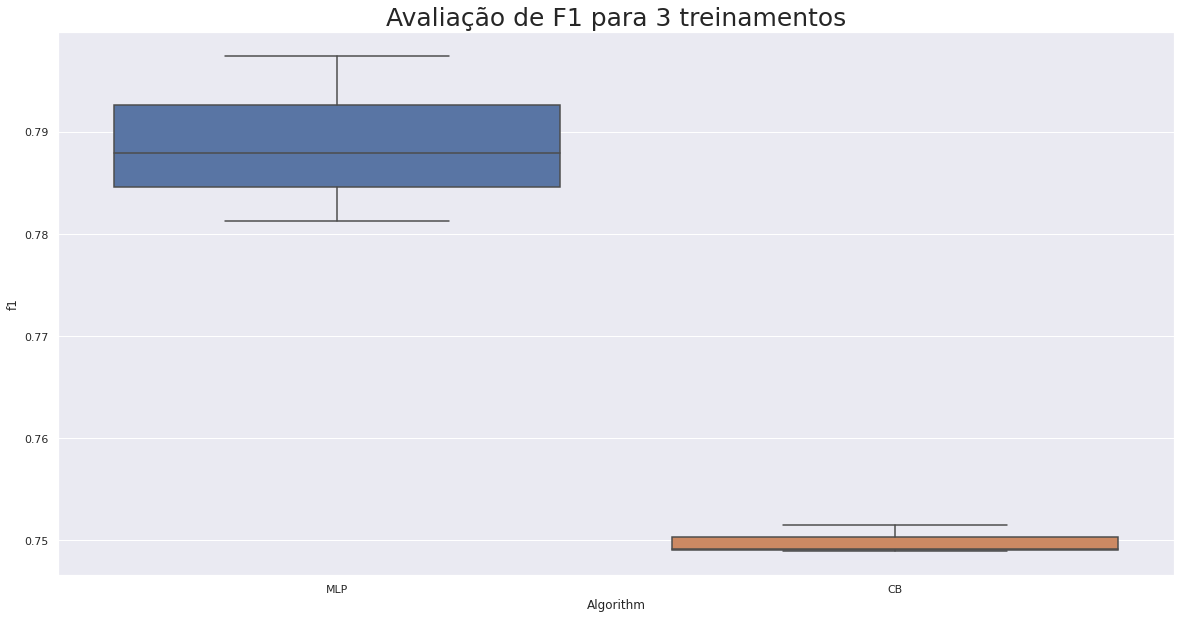

In [14]:
display_side_by_side([evaluation_summary_frame], ['Resumo das Execuções'])

for column in ['f1']:
    plt.figure(figsize=(20,10))
    ax = sns.boxplot(x="Algorithm", y=column, data=evaluation_frame)
    ax.set_title(f'Avaliação de {column.capitalize()} para {training_repetitions} treinamentos', fontdict={'fontsize':25});